In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import time
import pandas as pd


from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from batch_gen import BatchGenerator

import seaborn as sns
import numpy as np
import copy
import matplotlib.pyplot as plt

## Set GPU device ##x
GPU    = 3
device = torch.device("cuda:{}".format(GPU) if torch.cuda.is_available() else "cpu")
seed   = 1538574472
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
print("Device:", device)

dataset       = 'gtea'
features_path = f'../data/{dataset}/features/'
gt_path       = f'../data/{dataset}/groundTruth/'
mapping_file  = f'../data/{dataset}/mapping.txt'
vid_list_file = f'../data/{dataset}/splits/train.split4.bundle'
batch_size    = 1



split  = '4'
op     = 'none'
method = 'triplet_11'

if dataset  == "50salads": sample_rate = 2
else: sample_rate = 1

    
    
actions_dict = dict()
file_ptr = open(mapping_file, 'r')
actions = file_ptr.read().split('\n')[:-1]
file_ptr.close()
for a in actions:
    actions_dict[a.split()[1]] = int(a.split()[0])
num_classes  = len(actions_dict)
    
I2A = {v: k for k, v in actions_dict.items()}
colors  = sns.color_palette("Set3",len(actions_dict)) ## 색상 지정


batch_gen = BatchGenerator(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
batch_gen.read_data(vid_list_file)

Device: cuda:3


In [2]:
from triplet import *
embedding_net = get_embedding_net()
triplet_model = TripletNet(embedding_net, actions_dict).to(device)
pretrained_weight = torch.load('../experiment/models/triplet/triplet_{}'.format(dataset))['model_state_dict']
triplet_model.load_state_dict(pretrained_weight)

<All keys matched successfully>

In [3]:
actions_dict

{'cut_tomato': 0,
 'place_tomato_into_bowl': 1,
 'cut_cheese': 2,
 'place_cheese_into_bowl': 3,
 'cut_lettuce': 4,
 'place_lettuce_into_bowl': 5,
 'add_salt': 6,
 'add_vinegar': 7,
 'add_oil': 8,
 'add_pepper': 9,
 'mix_dressing': 10,
 'peel_cucumber': 11,
 'cut_cucumber': 12,
 'place_cucumber_into_bowl': 13,
 'add_dressing': 14,
 'mix_ingredients': 15,
 'serve_salad_onto_plate': 16,
 'action_start': 17,
 'action_end': 18}

# Embedding plot & Bezier curve plot

In [4]:
import bezier
def embeddings3d_plot(embeddings, batch_target, name, step):
    fig = plt.figure(figsize=(10,10))
#     fig.suptitle(f"Embedding Plot: {name}")
    ax = fig.add_subplot(projection='3d')
    labels = np.array(batch_target.squeeze())
    frames = embeddings.shape[1]
    index = np.arange(0, frames, step)


    for i in index:
        c1 = colors[labels[i]]
        ax.scatter(
            embeddings[0, i],    # x-coordinates.
            embeddings[1, i],    # y-coordinates.
            embeddings[2, i],    # z-coordinates.
            s = 10,
            color=c1

        )
    path = f'./fig/{dataset}/embedding/{method}'
    if not os.path.exists(path):   os.makedirs(path)
    plt.savefig(f'{path}/{name}.jpeg')
    plt.show()
    plt.close()


def bezier3d_plot(embeddings, name, step):
    frames = embeddings.shape[1]
    index = np.arange(0, frames, step)

    embeddings_ = embeddings[:, index] # Controll Points
    curve = bezier.Curve.from_nodes(embeddings_)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')

    ## Bezier Curve ##
    nodes = curve.nodes
    num_frames = nodes.shape[-1]
    ts = np.arange(0, 1, 1/num_frames)
    curve_points = []
    for t in ts:
        curve_points.append(curve.evaluate(t).squeeze())


    curve_points = np.stack(curve_points).T

    ax.plot(
        curve_points[0, :],    # z-coordinates.
        curve_points[1, :],    # z-coordinates.
        curve_points[2, :],    # z-coordinates.
    )
    print(curve_points.shape)

    ax.scatter(
        curve_points[0, :],    # z-coordinates.
        curve_points[1, :],    # z-coordinates.
        curve_points[2, :],    # z-coordinates.
        c = 'red',
        s=5
    )
    
    ax.text(
        curve_points[0, 0],    # z-coordinates.
        curve_points[1, 0],    # z-coordinates.
        curve_points[2, 0],    # z-coordinates.
        s = 'START',
        fontsize=10
    )
    ax.text(
        curve_points[0, -1],    # z-coordinates.
        curve_points[1, -1],    # z-coordinates.
        curve_points[2, -1],    # z-coordinates.
        s = 'END',
        fontsize=10
    )
    path = f'./fig/{dataset}/bezier/{method}'
    if not os.path.exists(path):   os.makedirs(path)
    plt.savefig(f'{path}/{name}.jpeg')
    plt.show()
    plt.close()

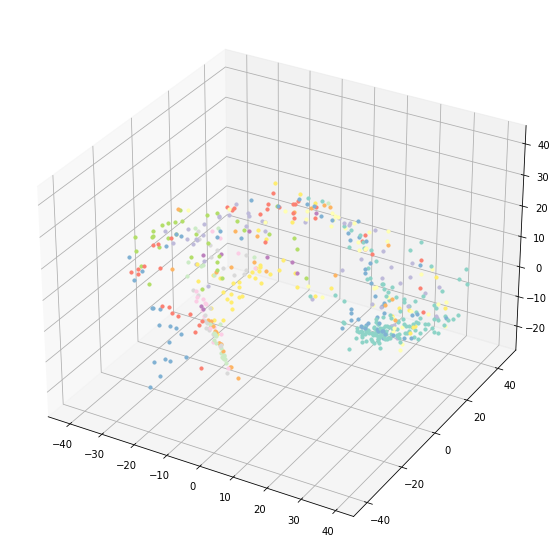

(3, 527)


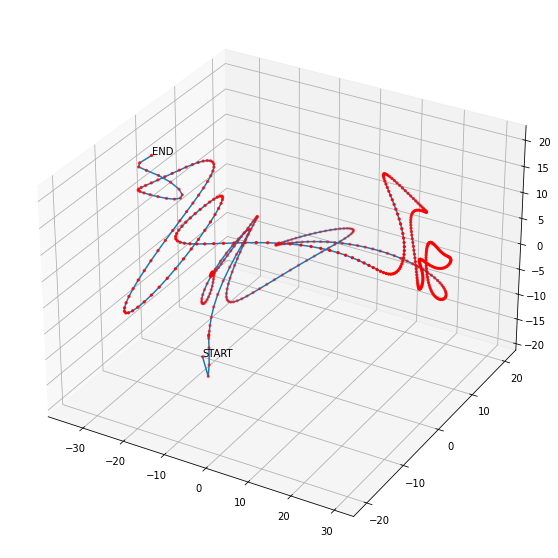

torch.Size([5792, 2048]) (3, 5792)


In [5]:
batch_gen = BatchGenerator(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
batch_gen.read_data(vid_list_file)
batch_gen.reset()
while batch_gen.has_next():
        batch_input, batch_target, mask, name = batch_gen.next_batch(1)

        name        = name[0][:-4]
        batch_input = batch_input.T.squeeze().to(device)
        frames      = batch_input.shape[0]
        step        = int(method.split('_')[-1])
        index       = np.arange(0, frames, step)
        
#         curvature   = np.load(f'../data/{dataset}/{method}/{name}.npy')

        embeddings = triplet_model.get_embedding(batch_input).T.detach().cpu().numpy()
        embeddings3d_plot(embeddings, batch_target, name, step)
        bezier3d_plot(embeddings, name, step)
        print(batch_input.shape, embeddings.shape)
        break

# Segmentation plot

In [78]:
def read(path):
    with open(path, 'r') as f:
        pred = f.readlines()[1].split(' ')

    return pred


def make_df(df_type, content):


    name = f'label_{df_type}'
    col   = f'{df_type}'
    cols = [ name, col ]
    df = pd.DataFrame(columns=cols)

    pivot = None

    for now in content:
        if pivot == None: # init
            pivot = 1
            count = 1
            index = 0
        if pivot == now:
            count += 1
        if pivot != now:
            df.at[index, name] = pivot
            df.at[index, col]   = count
            pivot = now
            index += 1
            count = 1
    df.at[index, name] = pivot
    df.at[index, col]   = count
    df = df.drop(index=0)

    return df

def make_colors( labels):
    result = []
    now = None
    for g in labels:
        if now == None:
            now = g
            result.append(colors[g])

        if now != g:
            now = g
            result.append(colors[g])

    return result


def seg_plot(df_type, frames, df_gt, df_pred1, df_pred2, curvature, g_colors, p1_colors, p2_colors, name, method, x1, x2, y1, y2):


    fig = plt.figure(figsize=(15, 10))
    print(name)
#     fig.suptitle(f'Segmentation Plot: {name}')
    ax1 = fig.add_subplot(4,1,1)
    ax2 = fig.add_subplot(4,1,2)
    ax3 = fig.add_subplot(4,1,3)
    ax4 = fig.add_subplot(4,1,4)
    ax1.tick_params(axis = 'y', labelsize =20)
    ax2.tick_params(axis = 'y', labelsize =20)
    ax4.tick_params(axis = 'y', labelsize =20)


    df_gt = df_gt.set_index(f'label_{df_type[0]}').T
    df_pred1 = df_pred1.set_index(f'label_{df_type[1]}').T
    df_pred2 = df_pred2.set_index(f'label_{df_type[2]}').T


    df_gt.plot.barh(ax = ax1, stacked=True, legend=False, color=g_colors)
    ax1.set_xlim(x1, x2)
    ax1.xaxis.set_visible(False)
#     ax1.set_xlim(0, frames)


    df_pred1.plot.barh(ax = ax2, stacked=True, legend=False, color=p1_colors)
    ax2.set_xlim(x1, x2)
    ax2.xaxis.set_visible(False)
#     ax2.set_xlim(0, frames)

    
    
    ax3.plot(curvature)
    ax3.set_xlim(x1, x2)
#     ax3.set_xlim(0, frames)
    ax3.set_ylim(y1, y2)
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    
    df_pred2.plot.barh(ax = ax4, stacked=True, legend=False, color=p2_colors)
    ax4.set_xlim(x1, x2)
    ax4.xaxis.set_visible(False)
#     ax4.set_xlim(0, frames)
    
#     path = f'./fig/{dataset}/segplot/{method}'
#     if not os.path.exists(path):   os.makedirs(path)
#     else: pass
#     plt.savefig(f'./fig/{dataset}/segplot/{method}/{name}.jpeg')
    plt.savefig(f'./pick/{method}_{name}.png')
    plt.show()
    plt.close()


In [61]:
methods = [f'triplet_{split}' for split in range(5, 9)]
methods.pop(3)
# methods = 'triplet_9'
# methods

'triplet_8'







 triplet_6 






S4_Tea_C1


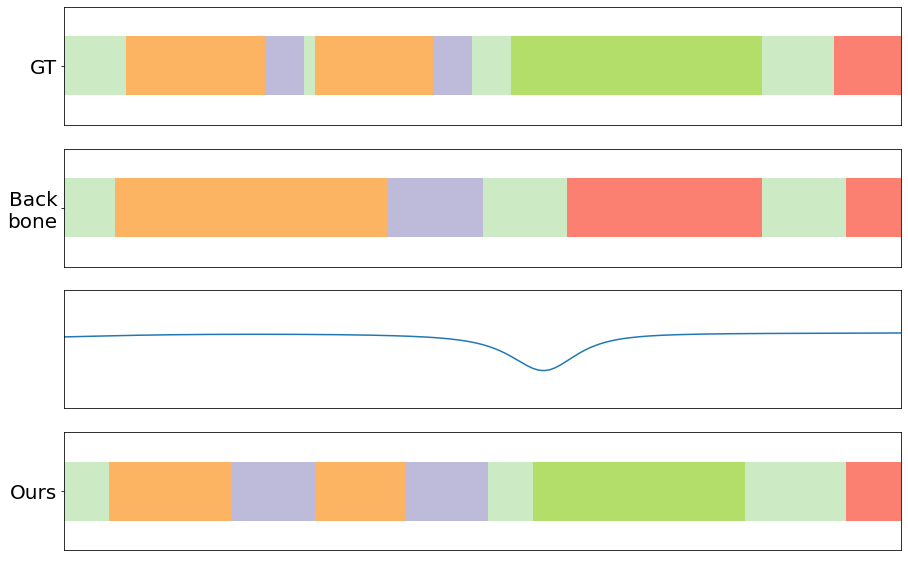

In [81]:
from IPython import display
action = 'test'
for method in methods:
    if method != 'triplet_6': continue
    print("\n\n\n\n\n\n {} \n\n\n\n\n\n".format(method))
    vid_list_file_tst =f"../data/{dataset}/splits/test.split4.bundle"
    batch_gen_tst = BatchGenerator(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
    
    batch_gen_tst.read_data(vid_list_file_tst)
    while batch_gen_tst.has_next():
        batch_input, batch_target, mask, name = batch_gen_tst.next_batch(1)
#         print(batch_input.shape[-1])
        x1, x2 = 850, 1000
#         x1, x2 = 0, batch_input.shape[-1]
        y1, y2 = 0.1, .4
        name        = name[0][:-4]
        if name !='S4_Tea_C1': continue
        batch_input = batch_input.T.squeeze().to(device)
        frames      = batch_input.shape[0]


        index       = np.arange(0, frames, step)
        path = f'../data/{dataset}/groundTruth/{name}.txt'

        with open(path, 'r') as f:
            gt = f.read().split('\n')[:-1]




        # GT
        g_result1 = []
        g_result2 = []

        # Pred
        p1_result1 = []
        p1_result2 = []

        p2_result1 = []
        p2_result2 = []


        path1 = f'./results/{dataset}/split_{split}/none/{name}' # backborn
        path2 = f'./results/{dataset}/split_{split}/{method}/{name}' # tripplet
        path3 = f'../data/{dataset}/{method}/{name}.npy'
        pred1 = read(path1)
        pred2 = read(path2)
        curvature = np.load(path3)

        for g, p1, p2 in zip(gt, pred1, pred2):
            g_result1.append(actions_dict[g])
            g_result2.append(g)

            p1_result1.append(actions_dict[p1])
            p1_result2.append(p1)

            p2_result1.append(actions_dict[p2])
            p2_result2.append(p2)


        df_gt = make_df('GT', g_result2)
        df_pred1 = make_df('Back\nbone', p1_result2)
        df_pred2 = make_df('Ours', p2_result2)



        g_colors = make_colors( g_result1)
        p1_colors = make_colors( p1_result1)
        p2_colors = make_colors( p2_result1)


        df_type = ['GT', 'Back\nbone', 'Ours']
        seg_plot(df_type, frames, df_gt, df_pred1, df_pred2, curvature, g_colors, p1_colors, p2_colors, name, method, x1, x2, y1, y2)


    #         break







 triplet_6 






S4_Tea_C1


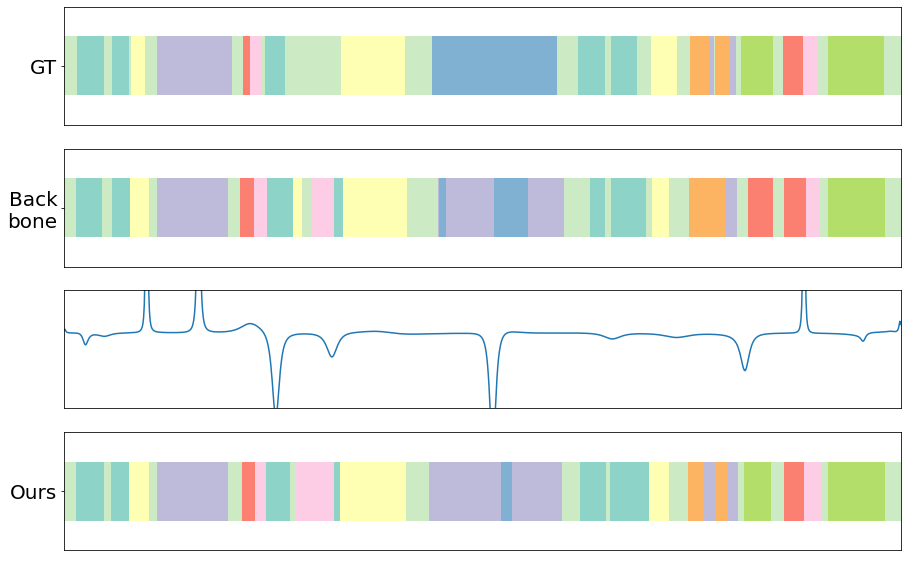

In [83]:
from IPython import display
action = 'test'
for method in methods:
    if method != 'triplet_6': continue
    print("\n\n\n\n\n\n {} \n\n\n\n\n\n".format(method))
    vid_list_file_tst =f"../data/{dataset}/splits/test.split4.bundle"
    batch_gen_tst = BatchGenerator(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
    
    batch_gen_tst.read_data(vid_list_file_tst)
    while batch_gen_tst.has_next():
        batch_input, batch_target, mask, name = batch_gen_tst.next_batch(1)
#         print(batch_input.shape[-1])
#         x1, x2 = 850, 1000
        x1, x2 = 0, batch_input.shape[-1]
        y1, y2 = 0.1, .4
        name        = name[0][:-4]
        if name !='S4_Tea_C1': continue
        batch_input = batch_input.T.squeeze().to(device)
        frames      = batch_input.shape[0]


        index       = np.arange(0, frames, step)
        path = f'../data/{dataset}/groundTruth/{name}.txt'

        with open(path, 'r') as f:
            gt = f.read().split('\n')[:-1]




        # GT
        g_result1 = []
        g_result2 = []

        # Pred
        p1_result1 = []
        p1_result2 = []

        p2_result1 = []
        p2_result2 = []


        path1 = f'./results/{dataset}/split_{split}/none/{name}' # backborn
        path2 = f'./results/{dataset}/split_{split}/{method}/{name}' # tripplet
        path3 = f'../data/{dataset}/{method}/{name}.npy'
        pred1 = read(path1)
        pred2 = read(path2)
        curvature = np.load(path3)

        for g, p1, p2 in zip(gt, pred1, pred2):
            g_result1.append(actions_dict[g])
            g_result2.append(g)

            p1_result1.append(actions_dict[p1])
            p1_result2.append(p1)

            p2_result1.append(actions_dict[p2])
            p2_result2.append(p2)


        df_gt = make_df('GT', g_result2)
        df_pred1 = make_df('Back\nbone', p1_result2)
        df_pred2 = make_df('Ours', p2_result2)



        g_colors = make_colors( g_result1)
        p1_colors = make_colors( p1_result1)
        p2_colors = make_colors( p2_result1)


        df_type = ['GT', 'Back\nbone', 'Ours']
        seg_plot(df_type, frames, df_gt, df_pred1, df_pred2, curvature, g_colors, p1_colors, p2_colors, name, method, x1, x2, y1, y2)


    #         break

In [82]:
df_gt

,label_GT,GT
1,background,18
2,take,37
3,background,10
4,take,24
5,background,3
6,open,19
7,background,17
8,pour,103
9,background,15
10,close,10








 triplet_5 






S4_CofHoney_C1


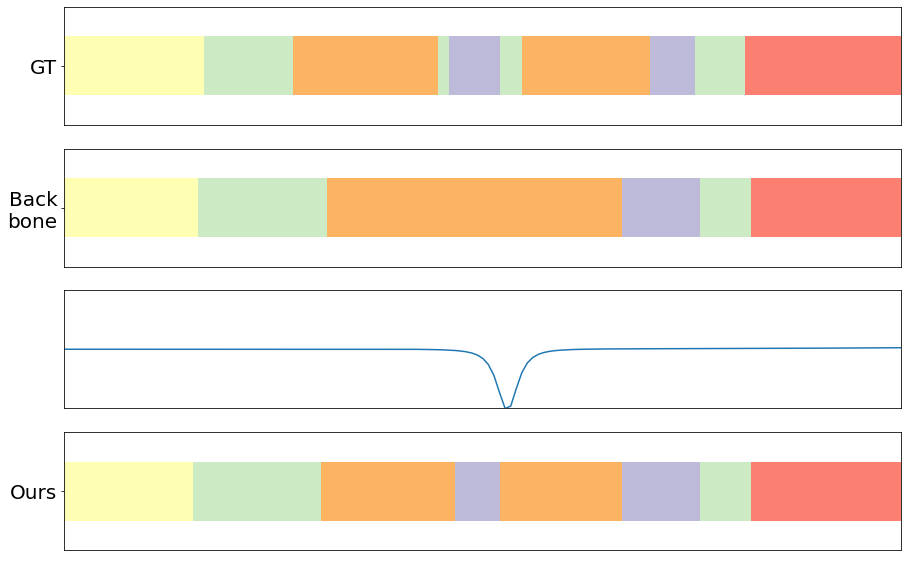

In [80]:
from IPython import display
action = 'test'
for method in methods:
    if method != 'triplet_5': continue
    print("\n\n\n\n\n\n {} \n\n\n\n\n\n".format(method))
    vid_list_file_tst =f"../data/{dataset}/splits/test.split4.bundle"
    batch_gen_tst = BatchGenerator(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
    
    batch_gen_tst.read_data(vid_list_file_tst)
    while batch_gen_tst.has_next():
        batch_input, batch_target, mask, name = batch_gen_tst.next_batch(1)
#         print(batch_input.shape[-1])
        x1, x2 = 150, 300
#         x1, x2 = 0, batch_input.shape[-1]
        y1, y2 = 0, 0.5
        name        = name[0][:-4]
        if name !='S4_CofHoney_C1': continue
        batch_input = batch_input.T.squeeze().to(device)
        frames      = batch_input.shape[0]


        index       = np.arange(0, frames, step)
        path = f'../data/{dataset}/groundTruth/{name}.txt'

        with open(path, 'r') as f:
            gt = f.read().split('\n')[:-1]




        # GT
        g_result1 = []
        g_result2 = []

        # Pred
        p1_result1 = []
        p1_result2 = []

        p2_result1 = []
        p2_result2 = []


        path1 = f'./results/{dataset}/split_{split}/none/{name}' # backborn
        path2 = f'./results/{dataset}/split_{split}/{method}/{name}' # tripplet
        path3 = f'../data/{dataset}/{method}/{name}.npy'
        pred1 = read(path1)
        pred2 = read(path2)
        curvature = np.load(path3)

        for g, p1, p2 in zip(gt, pred1, pred2):
            g_result1.append(actions_dict[g])
            g_result2.append(g)

            p1_result1.append(actions_dict[p1])
            p1_result2.append(p1)

            p2_result1.append(actions_dict[p2])
            p2_result2.append(p2)


        df_gt = make_df('GT', g_result2)
        df_pred1 = make_df('Back\nbone', p1_result2)
        df_pred2 = make_df('Ours', p2_result2)



        g_colors = make_colors( g_result1)
        p1_colors = make_colors( p1_result1)
        p2_colors = make_colors( p2_result1)


        df_type = ['GT', 'Back\nbone', 'Ours']
        seg_plot(df_type, frames, df_gt, df_pred1, df_pred2, curvature, g_colors, p1_colors, p2_colors, name, method, x1, x2, y1, y2)


    #         break







 triplet_5 






655
964
1244
805
1151
934
871
S4_CofHoney_C1


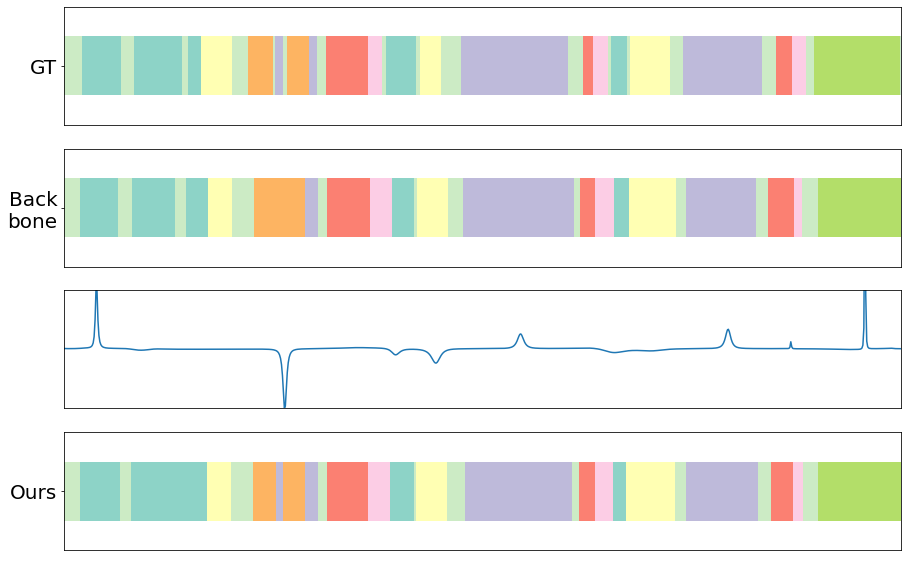

In [84]:
from IPython import display
action = 'test'
for method in methods:
    if method != 'triplet_5': continue
    print("\n\n\n\n\n\n {} \n\n\n\n\n\n".format(method))
    vid_list_file_tst =f"../data/{dataset}/splits/test.split4.bundle"
    batch_gen_tst = BatchGenerator(num_classes, actions_dict, gt_path, features_path, sample_rate, method)
    
    batch_gen_tst.read_data(vid_list_file_tst)
    while batch_gen_tst.has_next():
        batch_input, batch_target, mask, name = batch_gen_tst.next_batch(1)
        print(batch_input.shape[-1])
#         x1, x2 = 150, 300
#         x1, x2 = 0, batch_input.shape[-1]
        y1, y2 = 0, 0.5
        name        = name[0][:-4]
        if name !='S4_CofHoney_C1': continue
        batch_input = batch_input.T.squeeze().to(device)
        frames      = batch_input.shape[0]


        index       = np.arange(0, frames, step)
        path = f'../data/{dataset}/groundTruth/{name}.txt'

        with open(path, 'r') as f:
            gt = f.read().split('\n')[:-1]




        # GT
        g_result1 = []
        g_result2 = []

        # Pred
        p1_result1 = []
        p1_result2 = []

        p2_result1 = []
        p2_result2 = []


        path1 = f'./results/{dataset}/split_{split}/none/{name}' # backborn
        path2 = f'./results/{dataset}/split_{split}/{method}/{name}' # tripplet
        path3 = f'../data/{dataset}/{method}/{name}.npy'
        pred1 = read(path1)
        pred2 = read(path2)
        curvature = np.load(path3)

        for g, p1, p2 in zip(gt, pred1, pred2):
            g_result1.append(actions_dict[g])
            g_result2.append(g)

            p1_result1.append(actions_dict[p1])
            p1_result2.append(p1)

            p2_result1.append(actions_dict[p2])
            p2_result2.append(p2)


        df_gt = make_df('GT', g_result2)
        df_pred1 = make_df('Back\nbone', p1_result2)
        df_pred2 = make_df('Ours', p2_result2)



        g_colors = make_colors( g_result1)
        p1_colors = make_colors( p1_result1)
        p2_colors = make_colors( p2_result1)


        df_type = ['GT', 'Back\nbone', 'Ours']
        seg_plot(df_type, frames, df_gt, df_pred1, df_pred2, curvature, g_colors, p1_colors, p2_colors, name, method, x1, x2, y1, y2)


    #         break

In [85]:
df_gt

,label_GT,GT
1,background,18
2,take,41
3,background,14
4,take,49
5,background,7
6,take,13
7,open,33
8,background,16
9,scoop,26
10,background,2


In [86]:
# fig = plt.figure(figsize=(10,10))
# plt.rcParams.update({'font.size': 15})


# ax = fig.add_subplot(projection='3d')


# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])
# ax.zaxis.set_ticklabels([])

# ax.plot(
#     curve_points[0,12:16],
#     curve_points[1,12:16],
#     curve_points[2,12:16],
# )
# for i in range(12,16):
#     ax.scatter(
#         curve_points[0, i],    # z-coordinates.
#         curve_points[1, i],    # z-coordinates.
#         curve_points[2, i],    # z-coordinates.
#         c = 'red',
#         s=20
#     )
# ax.text(
#     curve_points[0, 12],    # z-coordinates.
#     curve_points[1, 12],    # z-coordinates.
#     curve_points[2, 12],    # z-coordinates.
#     s = '1st Frame'
# )
# ax.text(
#     curve_points[0, 13],    # z-coordinates.
#     curve_points[1, 13],    # z-coordinates.
#     curve_points[2, 13],    # z-coordinates.
#     s = '2nd Frame'
# )
# ax.text(
#     curve_points[0, 14],    # z-coordinates.
#     curve_points[1, 14],    # z-coordinates.
#     curve_points[2, 14],    # z-coordinates.
#     s = f' \'\'\' '
# )
# ax.text(
#     curve_points[0, 15],    # z-coordinates.
#     curve_points[1, 15],    # z-coordinates.
#     curve_points[2, 15],    # z-coordinates.
#     s = f'T Frame'
# )



# plt.savefig(f'4 points embedding.png')
# plt.show()
# plt.close()